# **Seminar 3 - Deep Learning tricks**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

## 1. Подготовка

### 1.1 Скачаем и подготовим данные

In [113]:
from torchvision import datasets
from IPython.display import clear_output
import matplotlib.pyplot as plt
import typing as tp
# %matplotlib inline

data = {}

# CIFAR10 ~ smaller, use this one if you want faster performance

# dataset_name = "CIFAR10"
# data['train'] = datasets.CIFAR10(root='./data', download=True, train=True)
# data['test'] = datasets.CIFAR10(root='./data', download=True, train=False)

# STL10 ~ bigger, use this one if you want more representitive results

dataset_name = "STL10"
data['train'] = datasets.STL10(root='./data', download=True, split='train')
data['test'] = datasets.STL10(root='./data', download=True, split='test')

clear_output(True)

train_size = len(data['train'])
test_size = len(data['test'])
img = data['train'][0][0]
img_size = [len(img.getbands()), *img.size]
if len(img_size) == 2:
    img_size = [1, *img_size]
classes = data['train'].classes
classes_ = '\n  --'.join(classes)
print(
    f'sizes:\n  train ~ {train_size}\n  test ~ {test_size}\n' +
    f'\noutput:\n  images of shape ~ {img_size}\n\n  classes:\n  --{classes_}'
)

sizes:
  train ~ 5000
  test ~ 8000

output:
  images of shape ~ [3, 96, 96]

  classes:
  --airplane
  --bird
  --car
  --cat
  --deer
  --dog
  --horse
  --monkey
  --ship
  --truck


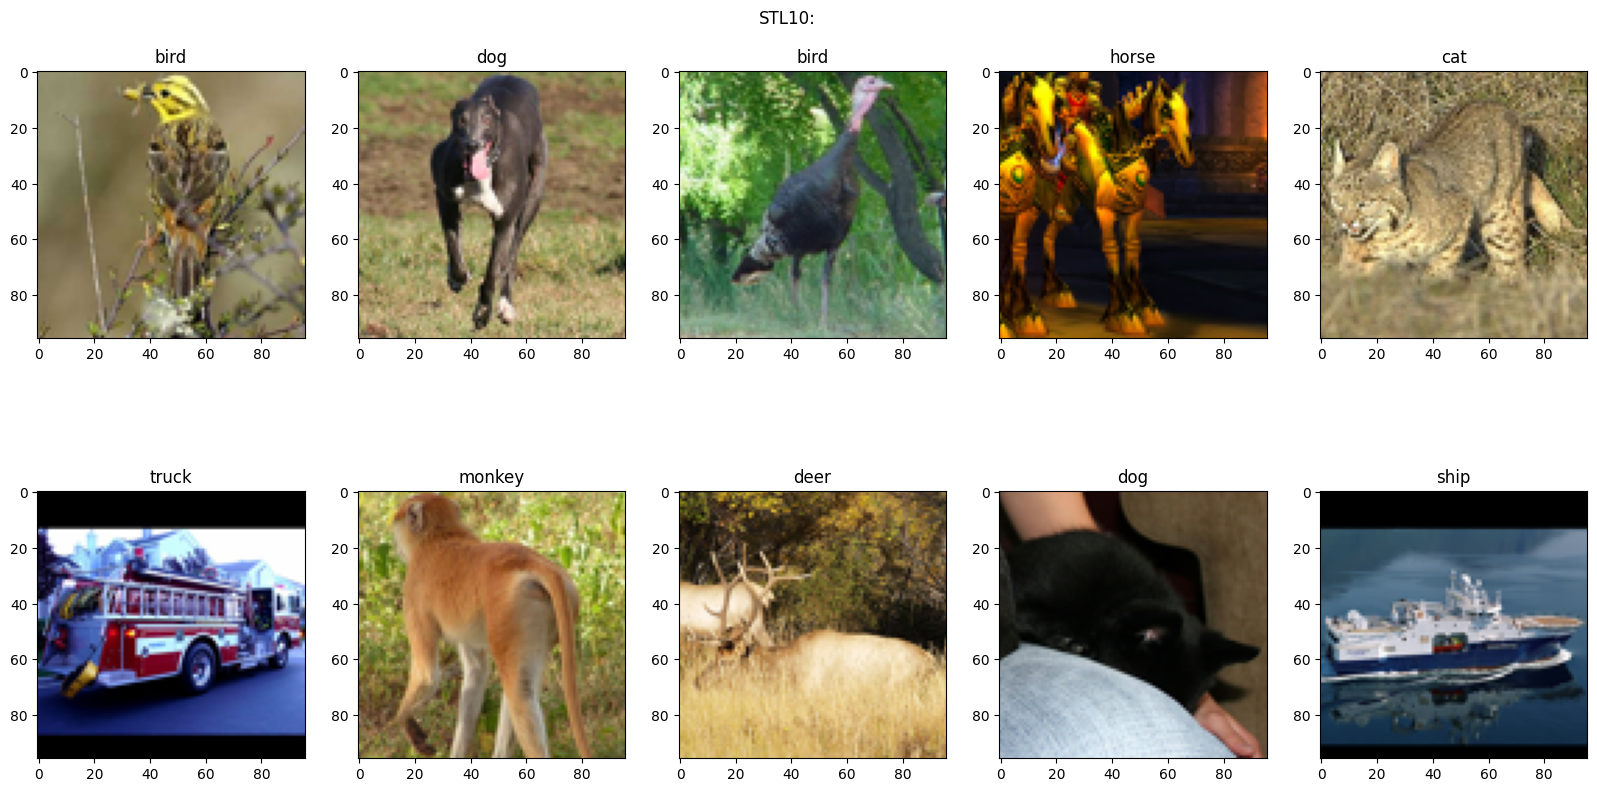

In [114]:
h = 2
w = 5

fig, ax = plt.subplots(h, w, figsize=(20, 5 * h))
fig.suptitle(f'{dataset_name}:', y=0.9)
for i, el in enumerate(data["train"]):
    if i >= h * w:
        break
    plt.subplot(h, w, i + 1)
    plt.imshow(el[0])
    plt.title(data["train"].classes[el[1]])
plt.show()

In [115]:
data['train'].data.shape, data['test'].data.shape, data['train'].data.dtype

((5000, 3, 96, 96), (8000, 3, 96, 96), dtype('uint8'))

In [116]:
import numpy as np
from tqdm.auto import tqdm, trange

channel_mean = np.zeros((img_size[0]))
channel_std = np.zeros((img_size[0]))

# img - PIL image, img.shape = (96, 96, 3)
for img, _ in tqdm(data['train']):
    img = np.array(img) / 255
    channel_mean += img.mean(axis=(0, 1))
    channel_std += img.std(axis=(0, 1))

channel_mean /= len(data['train'])
channel_std /= len(data['train'])

print(channel_mean, channel_std)

  0%|          | 0/5000 [00:00<?, ?it/s]

[0.44671062 0.43980984 0.40664645] [0.22414583 0.22148906 0.22389974]


In [117]:
import torch
from torch import nn
from torch.utils.data import Dataset, Subset
import torchvision.transforms as tr

class AddTransformsDataset(Dataset):
    # Class to add custom transforms to any dataset
    def __init__(self, dataset, transforms=None, indices=None):
        if indices is not None:
            self.dataset = Subset(dataset, indices)
        else:
            self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self) -> int:
        return self.dataset.__len__()
    
    def __getitem__(self, index: int):
        image, label = self.dataset[index]
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [118]:
tmp_dataset = AddTransformsDataset(data["train"], None)
img, label = tmp_dataset[0]
print(label, classes[label])
img

del tmp_dataset

1 bird


[Иллюстрации аугументаций из библиотеки torchvision.transforms](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)

[Общая дока по torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

[Albumentations](https://albumentations.ai/) и их же [Github](https://github.com/albumentations-team/albumentations)

In [119]:
data['train'].data.shape

(5000, 3, 96, 96)

Important note: read transforms' docs carefully, some of them are designed for PIL images, others for pytorch tensors (differences in shape)

In this case: tensors have shapes (3, 96, 96), PIL images have (96, 96, 3)

Note on `collate_fn` parameter of `DataLoader`:

A custom `collate_fn` can be used to customize collation, e.g., padding sequential data to max length of a batch. See this section on more about `collate_fn`.

In [120]:
from torch.utils.data import DataLoader

def train_transform():
    return tr.Compose([
        tr.RandomHorizontalFlip(p=0.5),
        tr.ToTensor(),
        tr.Normalize(mean=channel_mean, std=channel_std),
    ])

def val_transform():
    return tr.Compose([
        tr.ToTensor(),
        tr.Normalize(mean=channel_mean, std=channel_std),
    ])

def make_dataloaders(
    data,
    batch_size=16,
    train_transform_function=None,
    val_transform_function=None,
    val_part=0.5,  # test is splitted into val and test with val_part size ratio
    num_workers=0,
):
    dataloaders = dict()
    
    ds_train = AddTransformsDataset(data['train'], train_transform_function())
    dataloaders['train'] = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
    )
    
    perm = torch.randperm(len(data['test']))
    val_size = round(len(data["test"]) * val_part)
    
    
    ds_val = AddTransformsDataset(data['test'], val_transform_function(), perm[:val_size])
    dataloaders['val'] = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )
    
    ds_test = AddTransformsDataset(data['test'], val_transform_function(), perm[val_size:])
    dataloaders['test'] = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )
    
    return dataloaders


dataloaders = make_dataloaders(
    data,
    batch_size=64, # 64 works well for CIFAR10
    train_transform_function=train_transform,
    val_transform_function=val_transform,
    val_part=0.5,
    num_workers=0,
)

print('sizes:')
for split in dataloaders:
    print(f'  {split} ~ {len(dataloaders[split].dataset)}')

sizes:
  train ~ 5000
  val ~ 4000
  test ~ 4000


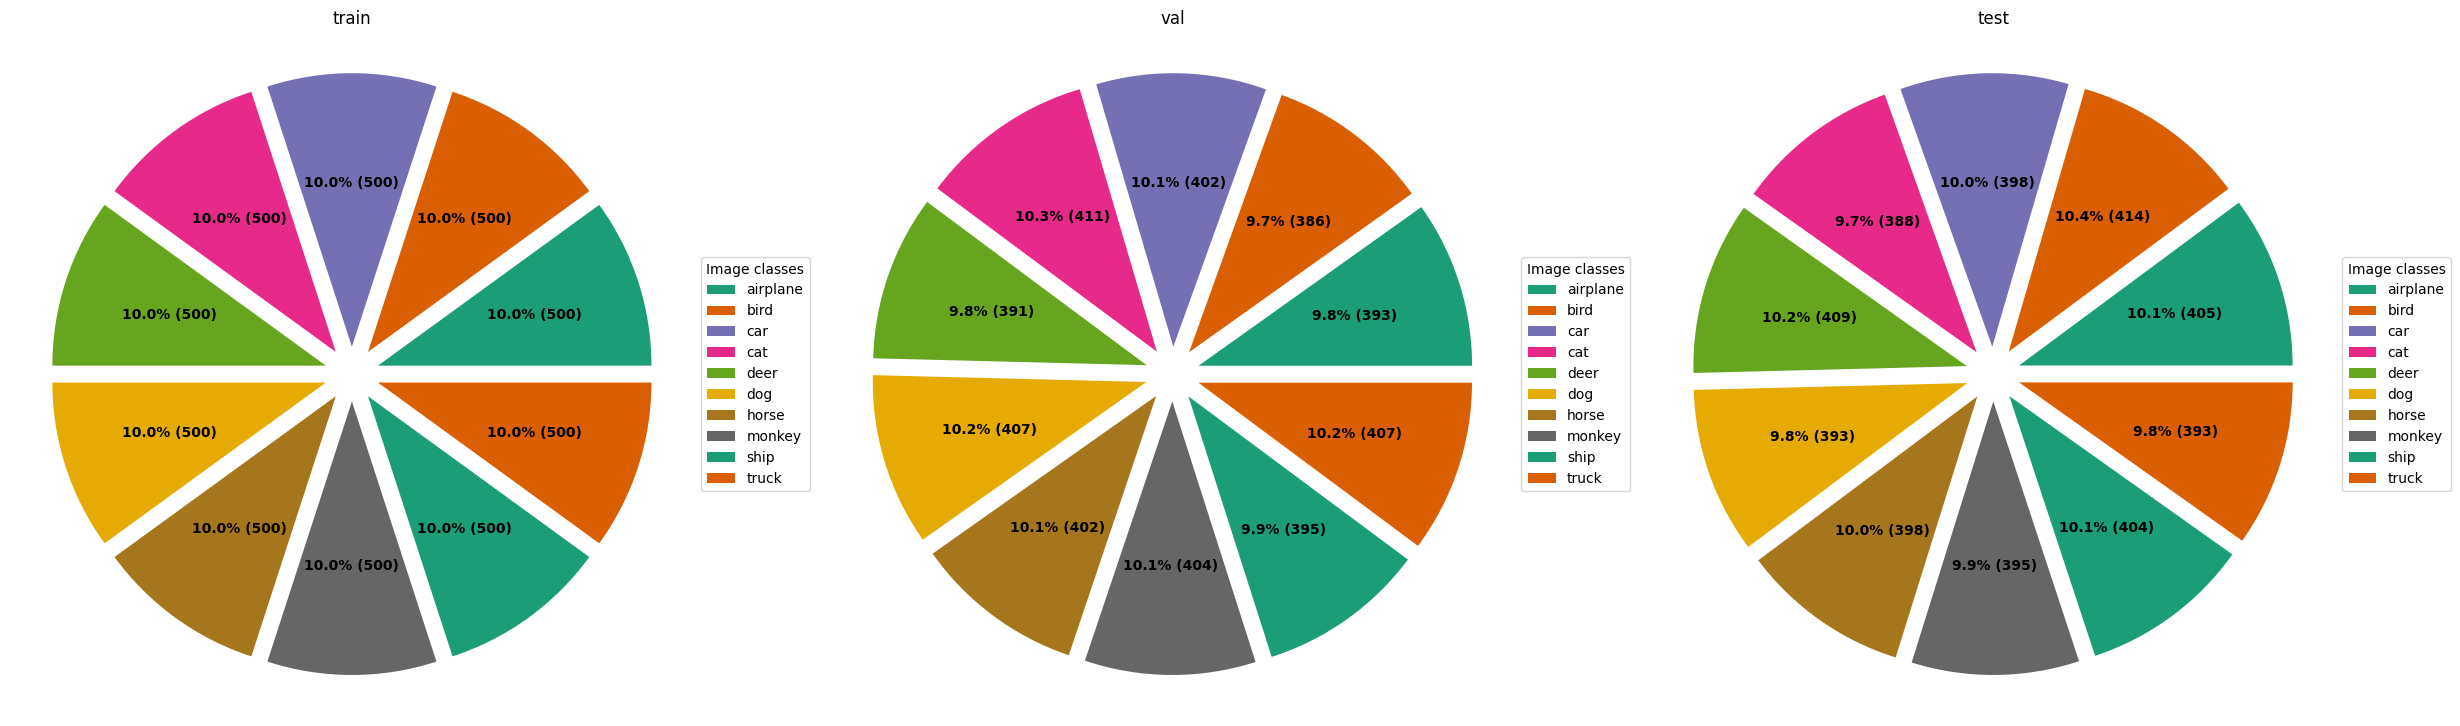

In [121]:
from collections import Counter

fig, ax = plt.subplots(1, 3, figsize=(30, 20))
for i, split in enumerate(dataloaders):
    plt.subplot(1, 3, i+1)
    plt.title(split)
    size = len(dataloaders[split].dataset)
    cnt = Counter([dataloaders[split].dataset[i][1]
                   for i in range(size)])
    wedges, texts, autotexts = plt.pie(
        [cnt[j] for j in range(len(classes))],
        autopct=lambda pct: '{:.1f}% ({:d})'.format(pct, int(pct/100.*size)),
        textprops=dict(color="black"),
        colors=plt.cm.Dark2.colors,
        startangle=0,
        explode=[0.1]*len(classes),
    )
    plt.legend(wedges, classes, title='Image classes', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight=700)
plt.show()

### 1.2 Базовая модель

Лучше ставить batchnorm до dropout чтобы из-за изменения числа обнуляемых каналов от запуска к запуску (или значений в тензоре) не плавали статистики. Но порядок применения этих операций все равно дискуссионный.

In [122]:
import numpy as np
import torch
from torch import nn
from collections import OrderedDict

# i means identity

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, dropout_p, pool, use_residual, num_convs):  
        super().__init__()
        self.num_convs = num_convs
        self.blocks = nn.Sequential()
        
        for idx in range(self.num_convs):
            self.block = nn.Sequential(OrderedDict([
                (f'conv', nn.Conv2d(in_channels=in_c if idx == 0 else out_c, out_channels=out_c, kernel_size=kernel_size, padding='same')),
                (f'bnorm', nn.BatchNorm2d(num_features=out_c)),
                (f'drop', nn.Dropout(p=dropout_p)),
                (f'act', activation)
            ]))
            self.blocks.append(self.block)
            
        self.pool = pool
        self.use_residual = use_residual
        if in_c != out_c and self.use_residual:
            # 1x1 convolution - to make the number of channels the same: at the output of self.block and residual
            self.conv1 = nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=1)
        else:
            self.conv1 = nn.Identity()

    def forward(self, x):
        if self.use_residual:  # if not first block
            return self.pool(self.blocks(x) + self.conv1(x))
        else:
            return self.pool(self.blocks(x))


class conv_net(nn.Module):
    """
        Simple convolutional network
    """
    def __init__(
        self,
        input_size,
        num_conv_layers,
        kernel_sizes,
        hidden_size,
        activations,
        dropouts,
        poolings,
        output_size,
        block_sizes=2,
        use_residual=True,
    ):
        super(conv_net, self).__init__()
        
        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        assert len(kernel_sizes) == num_conv_layers, f'provide {num_conv_layers} kernel_sizes or just one for all layers'
        
        # TODO: add option to have the same size for all hidden layers
        # assert isinstance(hidden_size, int), f'provide one hidden_size for all layers'
        # hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers
        if isinstance(hidden_size, list):
            assert len(hidden_size) == num_conv_layers
            hidden_sizes = [input_size[0]] + hidden_size
        else:
            hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers
        
        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        assert len(activations) == num_conv_layers, f'provide {num_conv_layers} activation functions or just one for all layers'
        
        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_conv_layers
        assert len(dropouts) == num_conv_layers, f'provide {num_conv_layers} dropout values or just one for all layers'
        
        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        assert len(poolings) == num_conv_layers, f'provide {num_conv_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_conv_layers)]) == num_conv_layers, \
               f'each pooling should be one of {available_poolings}'
    
        
        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_conv_layers)]
    
        self.conv_blocks = nn.Sequential(*[residual_block(
            in_c=hidden_sizes[i],
            out_c=hidden_sizes[i+1],
            kernel_size=kernel_sizes[i],
            activation=activations[i],
            dropout_p=dropouts[i],
            pool=self.poolings[i],
            use_residual=use_residual,
            num_convs=block_sizes
        ) for i in range(num_conv_layers)])

        
        head = [
            ('hid2out', nn.Linear(hidden_sizes[-1], output_size)),
            ('log_softmax', nn.LogSoftmax(dim=-1))
        ]
        self.head = nn.Sequential(OrderedDict(head))
    
    def forward(self, imgs):
        out3d = self.conv_blocks(imgs)
        out1d = torch.amax(out3d, dim=(2, 3))  # Global max pooling
        return self.head(out1d)

In [123]:
model = conv_net(
    input_size = img_size,
    num_conv_layers = 5,
    kernel_sizes = 5,
    hidden_size = 50,
    activations = nn.LeakyReLU(0.2),
    dropouts = 0.2,
    poolings = nn.AvgPool2d,
    output_size = len(classes),
    block_sizes=2,
    use_residual=True,
)

print('Model:', model, sep='\n')

imgs_batch, lbls_batch = next(iter(dataloaders['train']))

print(f'\nInput shape: {imgs_batch.shape}')
out = model(imgs_batch)
print(f'Output shape: {out.shape}')

prob_sums = out.exp().sum(-1).detach().numpy()
assert np.allclose(prob_sums, 1), 'all exp-sums must be close to 1, returned not log-probabilities'

Model:
conv_net(
  (conv_blocks): Sequential(
    (0): residual_block(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (bnorm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.2, inplace=False)
          (act): LeakyReLU(negative_slope=0.2)
        )
        (1): Sequential(
          (conv): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (bnorm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.2, inplace=False)
          (act): LeakyReLU(negative_slope=0.2)
        )
      )
      (block): Sequential(
        (conv): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (bnorm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.2, inplace=False)
        (act): LeakyRe

In [124]:
for name, param in model.named_parameters():
    print(name)

conv_blocks.0.blocks.0.conv.weight
conv_blocks.0.blocks.0.conv.bias
conv_blocks.0.blocks.0.bnorm.weight
conv_blocks.0.blocks.0.bnorm.bias
conv_blocks.0.blocks.1.conv.weight
conv_blocks.0.blocks.1.conv.bias
conv_blocks.0.blocks.1.bnorm.weight
conv_blocks.0.blocks.1.bnorm.bias
conv_blocks.0.conv1.weight
conv_blocks.0.conv1.bias
conv_blocks.1.blocks.0.conv.weight
conv_blocks.1.blocks.0.conv.bias
conv_blocks.1.blocks.0.bnorm.weight
conv_blocks.1.blocks.0.bnorm.bias
conv_blocks.1.blocks.1.conv.weight
conv_blocks.1.blocks.1.conv.bias
conv_blocks.1.blocks.1.bnorm.weight
conv_blocks.1.blocks.1.bnorm.bias
conv_blocks.2.blocks.0.conv.weight
conv_blocks.2.blocks.0.conv.bias
conv_blocks.2.blocks.0.bnorm.weight
conv_blocks.2.blocks.0.bnorm.bias
conv_blocks.2.blocks.1.conv.weight
conv_blocks.2.blocks.1.conv.bias
conv_blocks.2.blocks.1.bnorm.weight
conv_blocks.2.blocks.1.bnorm.bias
conv_blocks.3.blocks.0.conv.weight
conv_blocks.3.blocks.0.conv.bias
conv_blocks.3.blocks.0.bnorm.weight
conv_blocks.3.bl

In [125]:
# Counting how many parameters does our model have
def pretty_num(num):
    num = str(num)
    num = reversed([num[max(0, i-2):i+1] for i in range(len(num)-1, -1, -3)])
    return ".".join(num)

def model_num_params(model, print_=True):
    sum_params = 0
    for param in model.named_parameters():
        num_params = param[1].numel()
        if print_:
            print('{: <35} ~  {: <7} params'.format(param[0], pretty_num(num_params)))
        sum_params += num_params
    print(f'\nIn total: {pretty_num(sum_params)} params')
    return sum_params

sum_params = model_num_params(model)

conv_blocks.0.blocks.0.conv.weight  ~  3.750   params
conv_blocks.0.blocks.0.conv.bias    ~  50      params
conv_blocks.0.blocks.0.bnorm.weight ~  50      params
conv_blocks.0.blocks.0.bnorm.bias   ~  50      params
conv_blocks.0.blocks.1.conv.weight  ~  62.500  params
conv_blocks.0.blocks.1.conv.bias    ~  50      params
conv_blocks.0.blocks.1.bnorm.weight ~  50      params
conv_blocks.0.blocks.1.bnorm.bias   ~  50      params
conv_blocks.0.conv1.weight          ~  150     params
conv_blocks.0.conv1.bias            ~  50      params
conv_blocks.1.blocks.0.conv.weight  ~  62.500  params
conv_blocks.1.blocks.0.conv.bias    ~  50      params
conv_blocks.1.blocks.0.bnorm.weight ~  50      params
conv_blocks.1.blocks.0.bnorm.bias   ~  50      params
conv_blocks.1.blocks.1.conv.weight  ~  62.500  params
conv_blocks.1.blocks.1.conv.bias    ~  50      params
conv_blocks.1.blocks.1.bnorm.weight ~  50      params
conv_blocks.1.blocks.1.bnorm.bias   ~  50      params
conv_blocks.2.blocks.0.conv.

### 1.3 Оптимайзер

Добавляем в список параметров только оптимизируемые

In [126]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    params = []
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
    
    optimizer = torch.optim.Adam(params, lr, [beta1, beta2])
    return model, optimizer

In [127]:
model_params = {
    'input_size': img_size,
    'num_conv_layers': 5,
    'kernel_sizes': 5,
    'hidden_size': [10, 20, 30, 40, 50], # 50
    'activations': nn.LeakyReLU(0.2),
    'dropouts': 0.1,
    'poolings': nn.MaxPool2d,
    'output_size': len(classes),
}

model, optimizer = create_model_and_optimizer(
    model_class = conv_net, 
    model_params = model_params,
    lr = 1e-3,
)

### 1.4 Обучение/валидация на одном шаге

CrossEntropyLoss <---> LogSoftmax + NLLLoss

```python
# Note on numerically stable softmax computation:

def stable_softmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax

# input vector
In [267]: vec = np.array([1, 2, 3, 4, 5])
In [268]: stable_softmax(vec)
Out[268]: array([ 0.01165623,  0.03168492,  0.08612854,  0.23412166,  0.63640865])

# input vector with really large number, prone to overflow issue
In [269]: vec = np.array([12345, 67890, 99999999])
In [270]: stable_softmax(vec)
Out[270]: array([ 0.,  0.,  1.])
```

In [128]:
import torch.nn.functional as F

criterion = nn.NLLLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        out = model(images)
        loss = criterion(out, targets)
        
        loss.backward()
        optimizer.step()
        
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

@torch.no_grad()
def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names:
        metrics = {name: [] for name in metric_names}

    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        out = model(images)
        loss = criterion(out, targets)
        losses_val.append(loss.item())
        
        if metric_names:
            if 'accuracy' in metrics:
                _, pred_classes = torch.max(out, dim=-1)
                metrics['accuracy'].append((pred_classes == targets).float().mean().item())

    if metric_names:
        for name in metrics:
            metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

### 1.5 Цикл обучения

In [129]:
from IPython.display import clear_output

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, metric_names=None):
    losses = {'train': [], 'val': []}
    if metric_names:
        metrics = {name: [] for name in metric_names}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names)
            losses['val'].append(loss)
            if metric_names:
                for name in metrics_:
                    metrics[name].append(metrics_[name])
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 2 if metric_names else 1
            fig, ax = plt.subplots(1, ww, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww, 1)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            if metric_names:
                plt.subplot(1, ww, 2)
                plt.title('additional metrics')
                for name in metric_names:
                    plt.plot(metrics[name], '.-', label=name)
                plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses, metrics if metric_names else None

### 1.6 Обучаем базовую модель

In [130]:
models_params = dict()
models = dict()
optimizers = dict()
schedulers = dict()
criterions = dict()
losses = dict()
metrics = dict()

In [134]:
model_type = 'basic'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params = {
    'input_size': img_size,
    'num_conv_layers': 5,
    'kernel_sizes': 3,
    'hidden_size': [10, 20, 30, 40, 50],
    'activations': nn.ReLU(),
    'dropouts': 0.1,
    'poolings': nn.MaxPool2d,
    'output_size': len(classes),
    'use_residual': True,
    'block_sizes' : 3
}

models[model_type], optimizers[model_type] = create_model_and_optimizer(
    model_class = conv_net, 
    model_params = model_params,
    lr = 1e-3,
    device = device,
)

schedulers[model_type] = None

criterions[model_type] = nn.NLLLoss()

print(models[model_type])
_ = model_num_params(models[model_type], False)

conv_net(
  (conv_blocks): Sequential(
    (0): residual_block(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (bnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (act): ReLU()
        )
        (1): Sequential(
          (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (bnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (act): ReLU()
        )
        (2): Sequential(
          (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (bnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (act): ReLU()
        )
      )
      (block): Sequential(
        (c

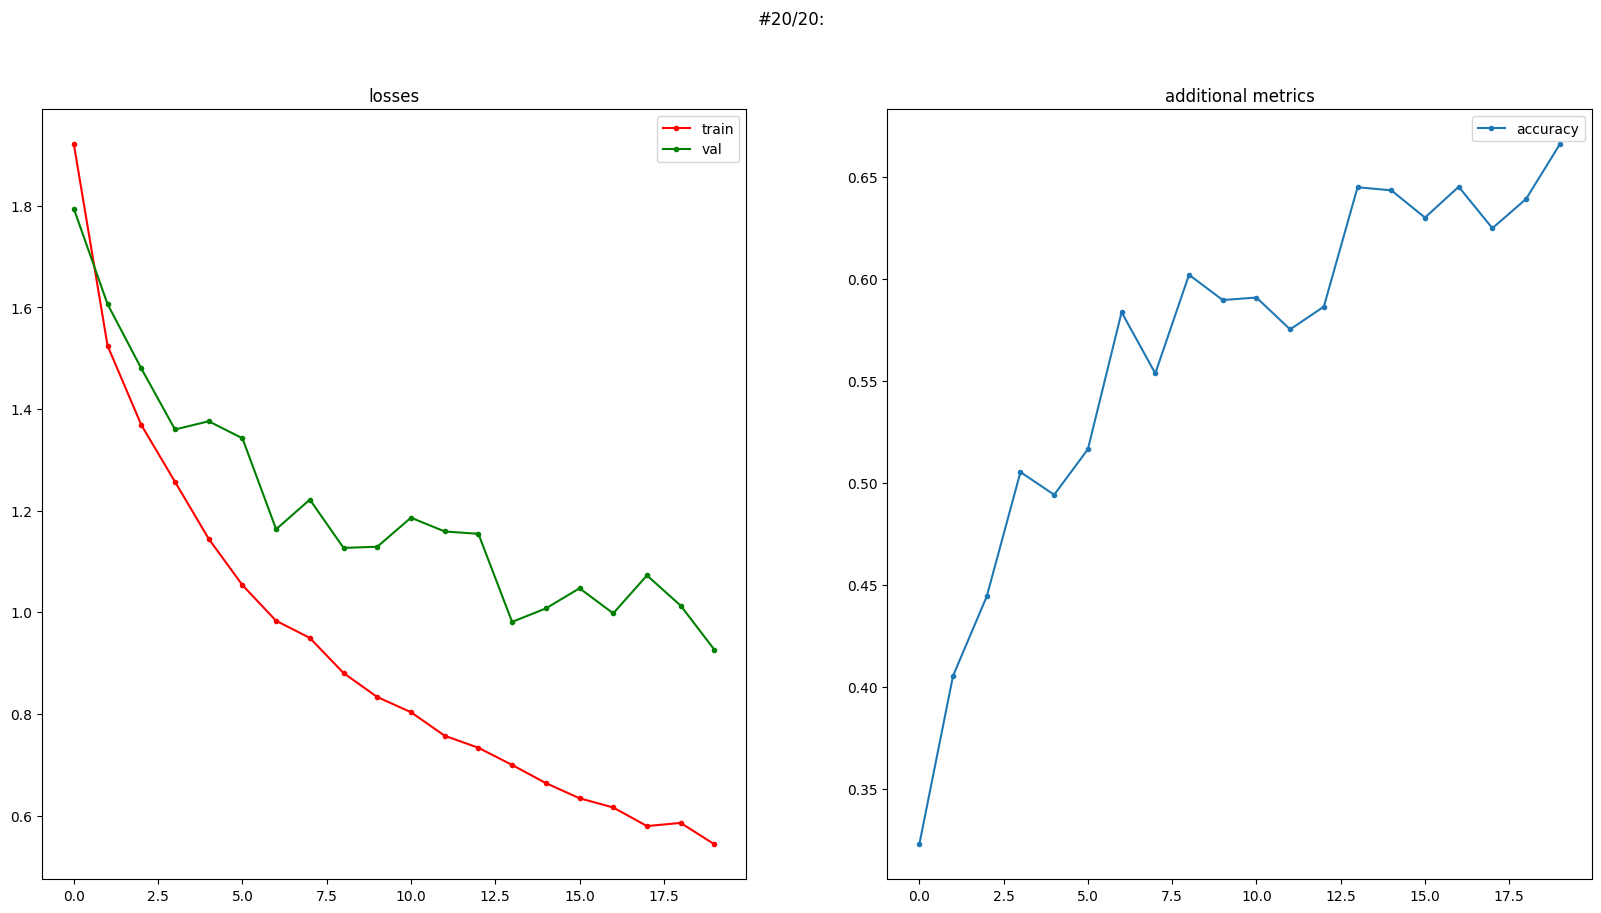

CPU times: total: 5min 29s
Wall time: 6min 8s


In [132]:
%%time
models[model_type], optimizers[model_type], losses[model_type], metrics[model_type] = learning_loop(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 20,
    min_lr = None,
    metric_names = {'accuracy'},
)

## 2. Интересные методы над уже обученными моделями

### 2.1 Finetuning

Ситуация: поставлена задача, но данных непосредственно для этой задачи мало, при этом существуют датасеты близкие к данному

Идея: возьмём нейросеть полноценно обученную на схожую задачу и ___дообучим___ модель на наших данных

Предобученные модели для классификации изображений в PyTorch: https://pytorch.org/vision/stable/models.html

In [136]:
from torchvision import models as mds
from torchvision.models import ResNet18_Weights

model_type = 'resnet_finetune'

resnet_weights = mds.ResNet18_Weights.DEFAULT
models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

print(models[model_type])
_ = model_num_params(models[model_type], False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

По сути мы просто обучаемся не со случайного стартового состояния, а с уже обученного состояния

**ОЧЕНЬ ВАЖНО:** Используйте меньший learning rate, чтобы первыми несколькими шагами мы и не сломали бы всю предобработку

In [142]:
models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))  # change the final layer in-place

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-6, [0.9, 0.999])

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

print(models[model_type])
_ = model_num_params(models[model_type], False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

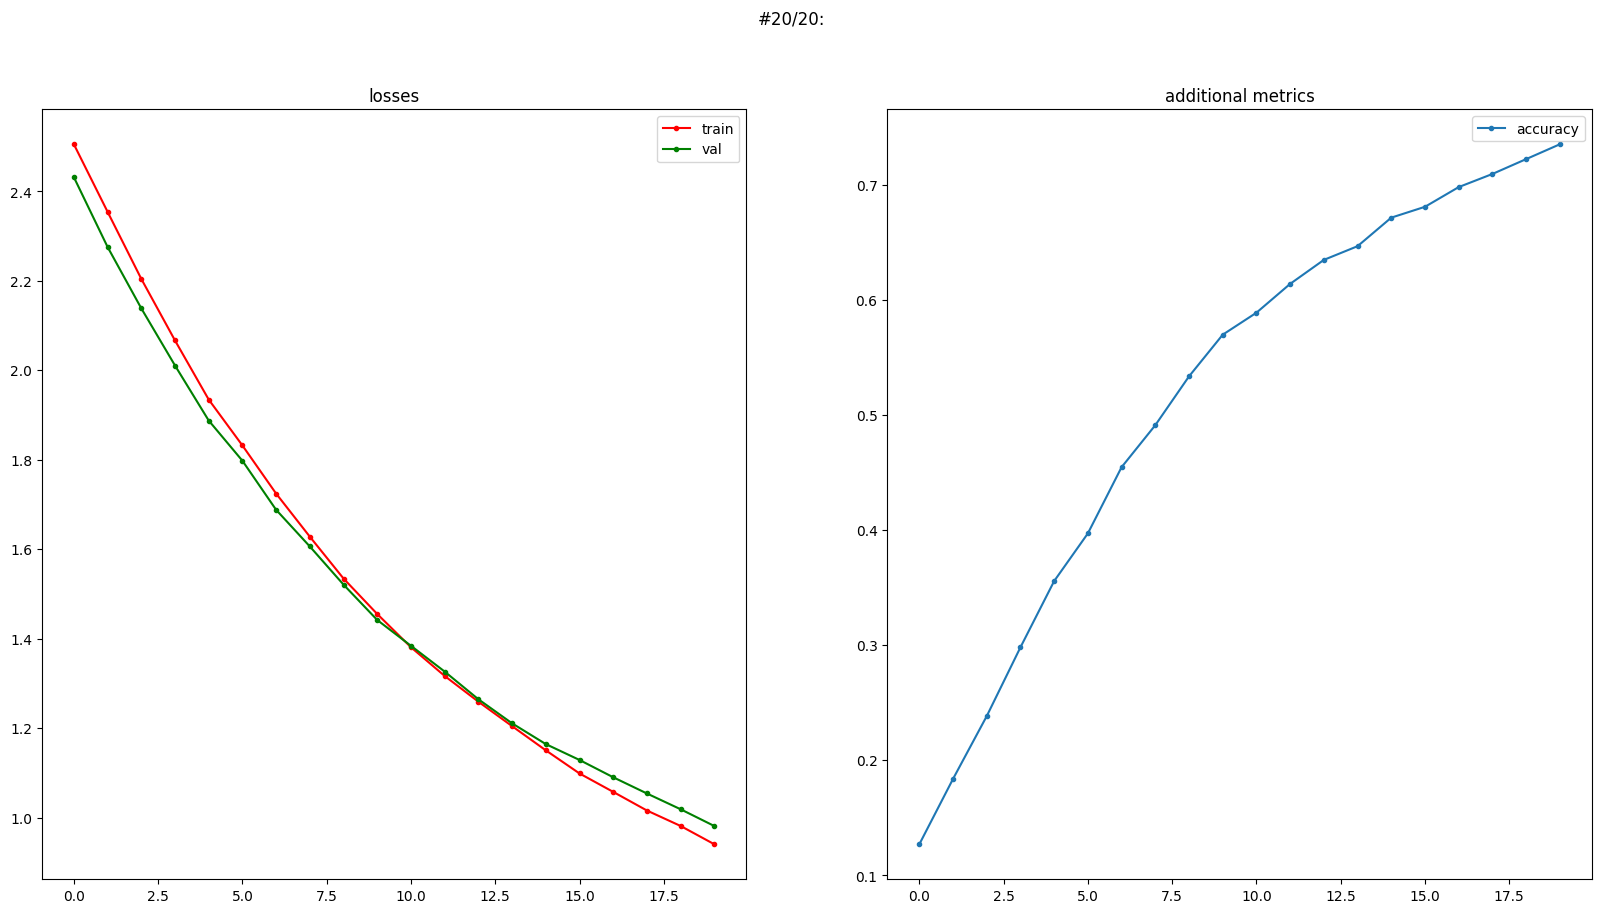

CPU times: total: 9min 39s
Wall time: 10min 25s


In [143]:
%%time
models[model_type], optimizers[model_type], losses[model_type], metrics[model_type] = learning_loop(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 20,
    min_lr = None,
    metric_names = {'accuracy'},
)

### 2.2 Transfer learning

Идея очень близкая к finetuning

Главная идея и отличие в том, что здесь мы уже хотим использовать предобученную модель чисто как фича-экстрактор. Мы замораживаем всю модель, кроме головы, а голову заменяем на необходимую нам

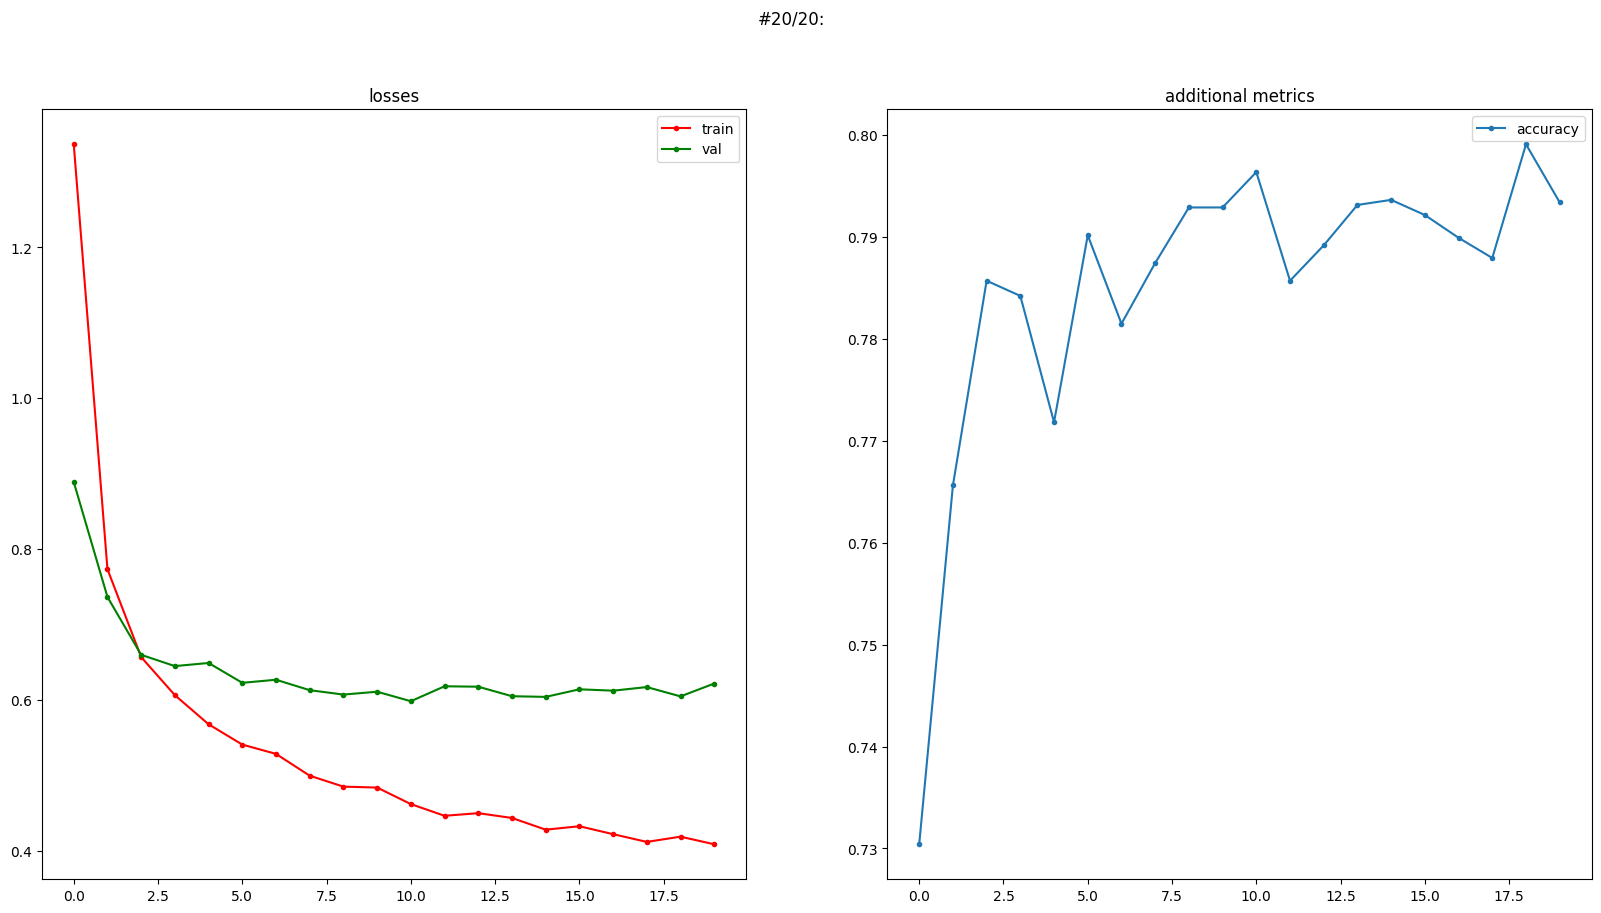

CPU times: total: 4min 59s
Wall time: 5min 35s


In [144]:
%%time

model_type = 'resnet_transfer'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], metrics[model_type] = learning_loop(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 20,
    min_lr = None,
    metric_names = {'accuracy'},
)

## 3. Что можно сделать с lr?

### 3.1 Learning rate schedulers

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop_with_lr(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, metric_names=None):
    losses = {'train': [], 'val': []}
    lrs = []
    if metric_names:
        metrics = {name: [] for name in metric_names}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names)
            losses['val'].append(loss)
            if metric_names:
                for name in metrics_:
                    metrics[name].append(metrics_[name])
            
            lrs.append(get_lr(optimizer))
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if metric_names else 2
            fig, ax = plt.subplots(1, ww, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww, 1)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww, 2)
            plt.title('learning rate')
            plt.plot(lrs, '.-', label='lr')
            plt.legend()
            
            if metric_names:
                plt.subplot(1, ww, 3)
                plt.title('additional metrics')
                for name in metric_names:
                    plt.plot(metrics[name], '.-', label=name)
                plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses, lrs, metrics if metric_names else None

lrs = dict()

In [ ]:
%%time

model_type = 'lr_exponential'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.ExponentialLR(
    optimizers[model_type],
    gamma=0.8,
    verbose=True,
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

In [ ]:
%%time

model_type = 'lr_cosine'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizers[model_type],
    T_max=50,
    verbose=True,
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

In [ ]:
%%time

model_type = 'lr_constant'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

In [ ]:
%%time

model_type = 'lr_linear'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.StepLR(
    optimizers[model_type],
    step_size=5,
    gamma=0.25,
    verbose=True,
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

In [ ]:
%%time

model_type = 'lr_on_plateau'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizers[model_type],
    mode='min',
    factor=0.25,
    patience=3,
    threshold=1e-4,
    verbose=True
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

**Сравним разные схемы**

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

k = 0
for model_type in models:
    if not model_type.startswith('lr'):
        continue
    ax[0].set_title('validation losses')
    ax[0].plot(losses[model_type]['val'], '-', color=colors[k], label=model_type[3:])
    ax[0].legend()
    
    ax[1].set_title('learning rate')
    ax[1].plot(lrs[model_type], '-', color=colors[k], label=model_type[3:])
    ax[1].legend()    
    
    ax[2].set_title('accuracy')
    ax[2].plot(metrics[model_type]['accuracy'], '-', color=colors[k], label=model_type[3:])
    ax[2].legend()
    
    k += 1
plt.show()

### 3.2 Warmup

Позволяет избежать "раннего переобучения", которое может произойти при неудачном батче

[Недавно появился torch ignite, но мы давайте напишем сами](https://pytorch.org/ignite/generated/ignite.handlers.param_scheduler.create_lr_scheduler_with_warmup.htmlhttps://pytorch.org/ignite/generated/ignite.handlers.param_scheduler.create_lr_scheduler_with_warmup.html)

In [ ]:
# From https://www.tutorialexample.com/implement-warm-up-scheduler-in-pytorch-pytorch-example/
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_epoch, min_lr=1e-9):
        self.warmup = warmup
        self.max_num_iters = max_epoch
        self.min_lr = min_lr
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch == 0:
            return [self.min_lr]
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [ ]:
%%time

model_type = 'lr_warmup'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = CosineWarmupScheduler(
    optimizer=optimizers[model_type],
    warmup=5,
    max_epoch=50,
    min_lr=1e-7,
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in np.linspace(0, 1, 7)]

k = 0
for model_type in models:
    if not model_type.startswith('lr'):
        continue
    ax[0].set_title('validation losses')
    ax[0].plot(losses[model_type]['val'], '-', color=colors[k], label=model_type[3:])
    ax[0].legend()
    
    ax[1].set_title('learning rate')
    ax[1].plot(lrs[model_type], '-', color=colors[k], label=model_type[3:])
    ax[1].legend()    
    
    ax[2].set_title('accuracy')
    ax[2].plot(metrics[model_type]['accuracy'], '-', color=colors[k], label=model_type[3:])
    ax[2].legend()
    
    k += 1
plt.show()

## 4. Борьба с переобучением

### 4.1 Label smoothing

Хотим ограничить уверенность модели в своих ответах (слишком уверена - риск переобучения)

Простое решение: ослабим таргет лейблы. Пусть теперь это будет не one-hot соответствующего класса, а ослабленный one-hot

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0] --> [0.1, 0.1, 0.1, 0.1, 0.91, 0.1, 0.1, 0.1, 0.1, 0.1]

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        """if smoothing == 0, it's one-hot method
           if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
%%time

model_type = 'label_smooth'

models[model_type] = mds.resnet18(weights=resnet_weights, progress=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizers[model_type],
    T_max=50,
    verbose=True,
)

criterions[model_type] = LabelSmoothingCrossEntropy(
    classes = len(classes),
    smoothing = 0.3,
    dim = -1,
    weight = None,
)

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy'},
)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in np.linspace(0, 1, 7)]

k = 0
for model_type in {'lr_cosine', 'label_smooth'}:
    ax[0].set_title('train losses')
    ax[0].plot(losses[model_type]['train'], '-', color=colors[k], label=model_type[3:])
    ax[0].legend()  
    
    ax[1].set_title('validation losses')
    ax[1].plot(losses[model_type]['val'], '-', color=colors[k], label=model_type[3:])
    ax[1].legend()
    
    ax[2].set_title('accuracy')
    ax[2].plot(metrics[model_type]['accuracy'], '-', color=colors[k], label=model_type[3:])
    ax[2].legend()
    
    k += 1
plt.show()

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

### 4.2 Temperature

$$\text{basic softmax}: \qquad b_i = \frac{\exp(a_i)}{\sum_i \exp(a_i)}$$
$$\text{softmax with temperature}: \qquad b_i = \frac{\exp(\frac{a_i}{t})}{\sum_i \exp(\frac{a_i}{t})}$$

По сути мы делаем то же что делали в label smoothing, но теперь мы это делаем не на уровне правильных ответов, а прямо на уровне предсказаний

А так же t - настраиваемый параметр, обычно хотим начинать с большой температуры и постепенно снижать её